The positive class (1) indicates a client that has payment difficulties, that is, he/she had late payment more than X days on at least one of the first Y installments of the loan in the sample.
The negative class (0) indicates all other cases.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import recall_score, precision_score, f1_score, make_scorer
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

### Loading the data

In [2]:
X_train = pd.read_csv("../data/Imbalanced_X_train.csv", index_col = ['SK_ID_CURR'])
y_train = pd.read_csv("../data/Imbalanced_y_train.csv")

X_test = pd.read_csv("../data/Imbalanced_X_test.csv", index_col = ['SK_ID_CURR'])
y_test = pd.read_csv("../data/Imbalanced_y_test.csv")

X_train_und = pd.read_csv('../data/Undersampled_X_train.csv', index_col = ['SK_ID_CURR'])
y_train_und = pd.read_csv('../data/Undersampled_y_train.csv')

X_test_und = pd.read_csv('../data/Rescaled_undersampled_X_test.csv', index_col = ['SK_ID_CURR'])

#1. Unbalanced dataset

###1.1. Training with all features

In [ ]:
# Randomized search to determine the best hyperparameters

params = {'criterion': ['entropy', 'gini'],
          'max_depth': range(40, 81),
          'min_samples_leaf': range(1, 10),
          'min_impurity_decrease': np.linspace(0, 0.5, 10)}

recall_scorer = make_scorer(recall_score)

rs = RandomizedSearchCV(DecisionTreeClassifier(random_state = 42), 
                        param_distributions = params, 
                        scoring = recall_scorer,
                        n_iter = 50,
                        random_state = 42,
                        verbose = 3)

rs.fit(X_train, y_train)

In [4]:
rs.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=52, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [ ]:
dt = rs.best_estimator_
dt.fit(X_train, y_train)

Saving an image of the generated tree

In [36]:
# Graphic representation of the tree

dot_data = export_graphviz(dt, 
                           out_file = None,
                           feature_names = list(X_train.columns), 
                           class_names = ['normalizado', 'atrasado'],
                           max_depth = 7,
                           filled = True,
                           rounded = True,
                           leaves_parallel = True)

graph = graphviz.Source(dot_data, format = "png") 
graph.render("decision_tree_depth_7")

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.932789 to fit


'decision_tree_depth_7.png'

Evaluation

In [6]:
pred = dt.predict(X_test)
print('Accuracy = ', dt.score(X_test, y_test))
print('Recall = ', recall_score(y_test, pred, average = None))
print('Precision = ', precision_score(y_test, pred, average = None))
print('F1 score = ', f1_score(y_test, pred, average = None))

Accuracy =  0.853608090308394
Recall =  [0.9192856  0.11921496]
Precision =  [0.92107702 0.11667748]
F1 score =  [0.92018044 0.11793257]


Confusion matrix

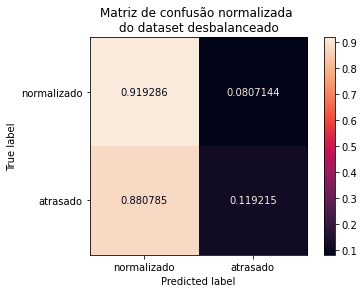

In [35]:
cm = plot_confusion_matrix(dt, X_test, y_test,
                           display_labels = ['normalizado', 'atrasado'],
                           cmap = 'rocket',
                           values_format = 'g',
                           normalize = 'true')
cm.ax_.set_title('Matriz de confusão normalizada \ndo dataset desbalanceado')
# plt.savefig('cm.png')
plt.show()

### 1.2. Training only with categorical features

In [8]:
cat_columns = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
               'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE',
               'FLAG_EMAIL', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
               'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY','LIVE_CITY_NOT_WORK_CITY']

In [9]:
X_train_cat = X_train.loc[:, cat_columns]
X_test_cat = X_test.loc[:, cat_columns]

In [ ]:
# Randomized search to determine the best hyperparameters

params = {'criterion': ['entropy', 'gini'],
          'max_depth': range(2, X_train_cat.shape[1]),
          'min_samples_split': range(2, 20),
          'min_impurity_decrease': np.linspace(0, 0.5, 10)}

rs_cat = RandomizedSearchCV(DecisionTreeClassifier(random_state = 42), 
                            param_distributions = params, 
                            scoring = recall_scorer,
                            n_iter = 50,
                            random_state = 42,
                            verbose = 3)

rs_cat.fit(X_train_cat, y_train)

In [11]:
rs_cat.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=9, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=9,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [ ]:
dt_cat = rs_cat.best_estimator_
dt_cat.fit(X_train_cat, y_train)

Saving an image of the generated tree

In [34]:
# Graphic representation of the tree

dot_data = export_graphviz(dt_cat, 
                           out_file = None,
                           feature_names = list(X_train_cat.columns), 
                           class_names = ['normalizado', 'atrasado'],
                           max_depth = 7,
                           filled = True,
                           rounded = True,
                           leaves_parallel = True)

graph = graphviz.Source(dot_data, format = "png") 
graph.render("decision_tree_cat_depth_7")

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.957344 to fit


'decision_tree_cat_depth_7.png'

Evaluation

In [13]:
pred_cat = dt_cat.predict(X_test_cat)
print('Accuracy = ', dt_cat.score(X_test_cat, y_test))
print('Recall = ', recall_score(y_test, pred_cat, average = None))
print('Precision = ', precision_score(y_test, pred_cat, average = None))
print('F1 score = ', f1_score(y_test, pred_cat, average = None))

Accuracy =  0.9178559376462776
Recall =  [9.99916985e-01 2.65216815e-04]
Precision =  [0.9179241  0.22222222]
F1 score =  [9.57167832e-01 5.29801325e-04]


Confusion matrix

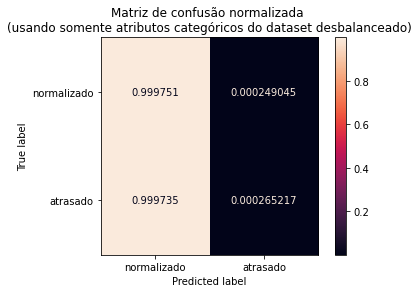

In [33]:
cm_cat = plot_confusion_matrix(dt_cat, X_test_cat, y_test,
                               display_labels = ['normalizado', 'atrasado'],
                               cmap = 'rocket',
                               values_format = 'g',
                               normalize = 'true')
cm_cat.ax_.set_title('Matriz de confusão normalizada \n(usando somente atributos categóricos do dataset desbalanceado)')
# plt.savefig('cm_cat.png')
plt.show()

#2. Balanced dataset

###2.1. Training with all features

In [ ]:
# Randomized search to determine the best hyperparameters

params = {'criterion': ['entropy', 'gini'],
          'max_depth': range(2, X_train_und.shape[1]),
          'min_samples_leaf': range(1, 21),
          'min_impurity_decrease': np.linspace(0, 0.5, 10)}

rs_und = RandomizedSearchCV(DecisionTreeClassifier(random_state = 42), 
                            param_distributions = params, 
                            scoring = recall_scorer,
                            n_iter = 50,
                            random_state = 42,
                            verbose = 3)

rs_und.fit(X_train, y_train)

In [17]:
rs_und.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=72, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=7, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [ ]:
dt_und = rs_und.best_estimator_
dt_und.fit(X_train_und, y_train_und)

Saving an image of the generated tree

In [32]:
# Graphic representation of the tree

dot_data = export_graphviz(dt_und, 
                           out_file = None,
                           feature_names = list(X_train_und.columns), 
                           class_names = ['normalizado', 'atrasado'],
                           max_depth = 7,
                           filled = True,
                           rounded = True,
                           leaves_parallel = True)

graph = graphviz.Source(dot_data, format = "png") 
graph.render("decision_tree_und_depth_7")

'decision_tree_und_depth_7.png'

Evaluation

In [19]:
pred_und = dt_und.predict(X_test_und)
print('Accuracy = ', dt_und.score(X_test_und, y_test))
print('Recall = ', recall_score(y_test, pred_und, average = None))
print('Precision = ', precision_score(y_test, pred_und, average = None))
print('F1 score = ', f1_score(y_test, pred_und, average = None))

Accuracy =  0.2141776340855404
Recall =  [0.15800147 0.8423286 ]
Precision =  [0.91806781 0.08211917]
F1 score =  [0.26960358 0.14964897]


Confusion matrix

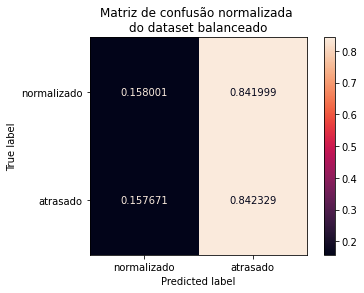

In [31]:
cm_und = plot_confusion_matrix(dt_und, X_test_und, y_test,
                               display_labels = ['normalizado', 'atrasado'],
                               cmap = 'rocket',
                               values_format = 'g',
                               normalize = 'true')
cm_und.ax_.set_title('Matriz de confusão normalizada \ndo dataset balanceado')
# plt.savefig('cm_und.png')
plt.show()

###2.2. Training only with categorical features

In [21]:
X_train_und_cat = X_train_und.loc[:, cat_columns]
X_test_und_cat = X_test_und.loc[:, cat_columns]

In [ ]:
# Randomized search to determine the best hyperparameters

params = {'criterion': ['entropy', 'gini'],
          'max_depth': range(2, X_train_und_cat.shape[1]),
          'min_samples_split': range(2, 20),
          'min_impurity_decrease': np.linspace(0, 0.5, 10)}

rs_und_cat = RandomizedSearchCV(DecisionTreeClassifier(random_state = 42), 
                                param_distributions = params, 
                                scoring = recall_scorer,
                                n_iter = 50,
                                random_state = 42,
                                verbose = 3)

rs_und_cat.fit(X_train_und_cat, y_train_und)

In [23]:
rs_und_cat.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=11,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [ ]:
dt_und_cat = rs_und_cat.best_estimator_
dt_und_cat.fit(X_train_und_cat, y_train_und)

Saving an image of the generated tree

In [29]:
# Graphic representation of the tree

dot_data = export_graphviz(dt_und_cat, 
                           out_file = None,
                           feature_names = list(X_train_und_cat.columns), 
                           class_names = ['normalizado', 'atrasado'],
                           max_depth = 7,
                           filled = True,
                           rounded = True,
                           leaves_parallel = True)

graph = graphviz.Source(dot_data, format = "png") 
graph.render("decision_tree_und_cat_depth_7")

'decision_tree_und_cat_depth_7.png'

Evaluation

In [25]:
pred_und_cat = dt_und_cat.predict(X_test_und_cat)
print('Accuracy = ', dt_und_cat.score(X_test_und_cat, y_test))
print('Recall = ', recall_score(y_test, pred_und_cat, average = None))
print('Precision = ', precision_score(y_test, pred_und_cat, average = None))
print('F1 score = ', f1_score(y_test, pred_und_cat, average = None))

Accuracy =  0.45505807561259703
Recall =  [0.44637224 0.55218141]
Precision =  [0.91766628 0.08189274]
F1 score =  [0.60059998 0.14263205]


Confusion matrix

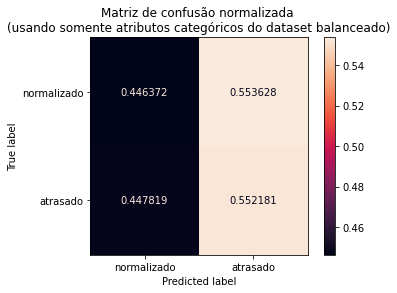

In [28]:
cm_und_cat = plot_confusion_matrix(dt_und_cat, X_test_und_cat, y_test,
                                   display_labels = ['normalizado', 'atrasado'],
                                   cmap = 'rocket',
                                   values_format = 'g',
                                   normalize = 'true')
cm_und_cat.ax_.set_title('Matriz de confusão normalizada \n(usando somente atributos categóricos do dataset balanceado)')
# plt.savefig('cm_und_cat.png')
plt.show()